In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import py7zr

Get dataset and unzip file

In [4]:
# ! wget https://ultravideo.fi/video/SunBath_3840x2160_50fps_420_8bit_YUV_RAW.7z
# ! wget https://ultravideo.fi/video/HoneyBee_1920x1080_120fps_420_8bit_YUV_RAW.7z

In [5]:
# with py7zr.SevenZipFile('SunBath_3840x2160_50fps_420_8bit_YUV_RAW.7z', mode='r') as z:
#     z.extractall(path='.')
# with py7zr.SevenZipFile('HoneyBee_1920x1080_120fps_420_8bit_YUV_RAW.7z', mode='r') as z:
    # z.extractall(path='.')

Read YUV File and save the 10th frame to a file

In [6]:
class VideoCaptureYUV:
    def __init__(self, filename, size):
        self.height, self.width = size
        self.shape = (self.height*3//2, self.width)
        self.frame_len = self.width * self.height * 3//2
        self.f = open(filename, 'rb')

    def read_raw(self):
        try:
            raw = self.f.read(self.frame_len)
            yuv = np.frombuffer(raw, dtype=np.uint8)
            yuv = yuv.reshape(self.shape)
        except Exception as e:
            print(str(e))
            return False, None
        return True, yuv

    def read(self):
        ret, yuv = self.read_raw()
        if not ret:
            return ret, yuv, yuv
        bgr = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB_I420)
        return ret, bgr, yuv

In [7]:
filename = "HoneyBee_1920x1080_120fps_420_8bit_YUV.yuv"
size = (1080, 1920)
cap = VideoCaptureYUV(filename, size)
framenum = 10
bgr4d = np.zeros(size+(3,framenum), dtype="uint8")
yuv4d = np.zeros(size+(3,framenum), dtype="uint8")

for i in range(framenum):
    ret, bgrframe, yuvframe = cap.read()
    if ret:
        bgr4d[:,:,:,i] = bgrframe
    else:
        break

cv2.imwrite("last_frame.png", bgrframe);
grayframe = cv2.cvtColor(bgrframe, cv2.COLOR_BGR2GRAY)

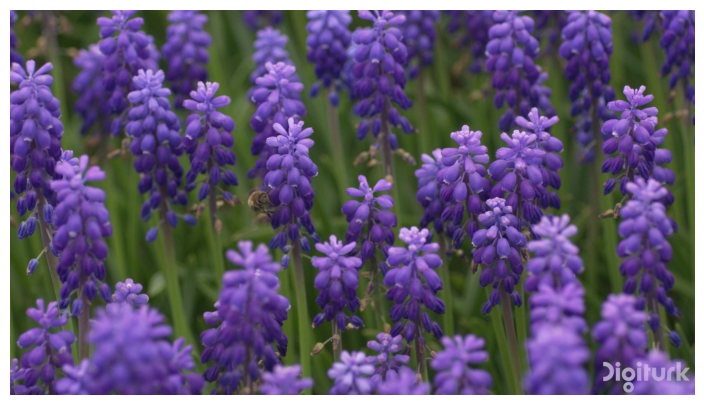

In [54]:
# cv2.imshow("frame", bgrframe)
# cv2.waitKey(0)
# cv2.destroyWindow("frame")
plt.figure(figsize=(10,5))
plt.imshow(bgrframe)
plt.axis("off");

In [23]:
def divnormcoeffs(img):
    #image dtype 
    image = img.astype('float')
    ksize = [5,5]

    oimg = np.zeros((img.shape[0]-ksize[0]+1,img.shape[1]-ksize[1]+1))

    for i in range(oimg.shape[0]):
        for j in range(oimg.shape[1]):
            patch = img[i:i+ksize[0],j:j+ksize[1]]
            patchcen = patch[ksize[0]//2, ksize[1]//2]
            m = np.mean(patch)
            s = np.std(patch)
            oimg[i,j] = (patchcen-m)/(s+1e-6)
    return oimg

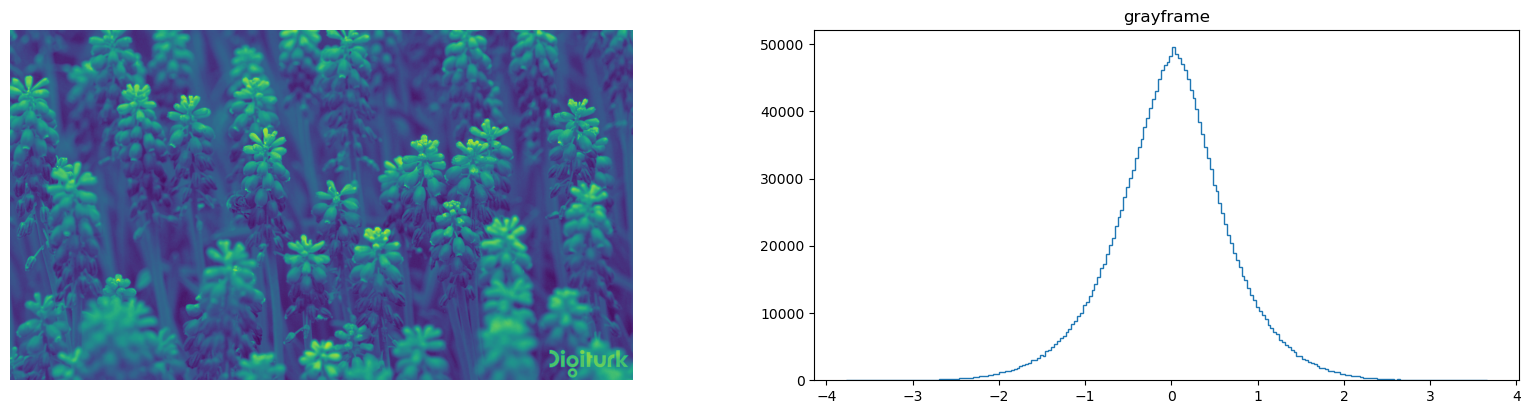

In [57]:
oimg = divnormcoeffs(grayframe)

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(grayframe); plt.axis("off");
plt.subplot(2,2,2)
counts, bins = np.histogram(oimg.flatten(), bins=222)
plt.stairs(counts, bins);
plt.title('grayframe');

We can see that the histogram obeys the Gaussian EPDF law as expected.

In [37]:
def blurimg(img, ksize, s):
    oimg = cv2.GaussianBlur(img, ksize, s)
    return oimg

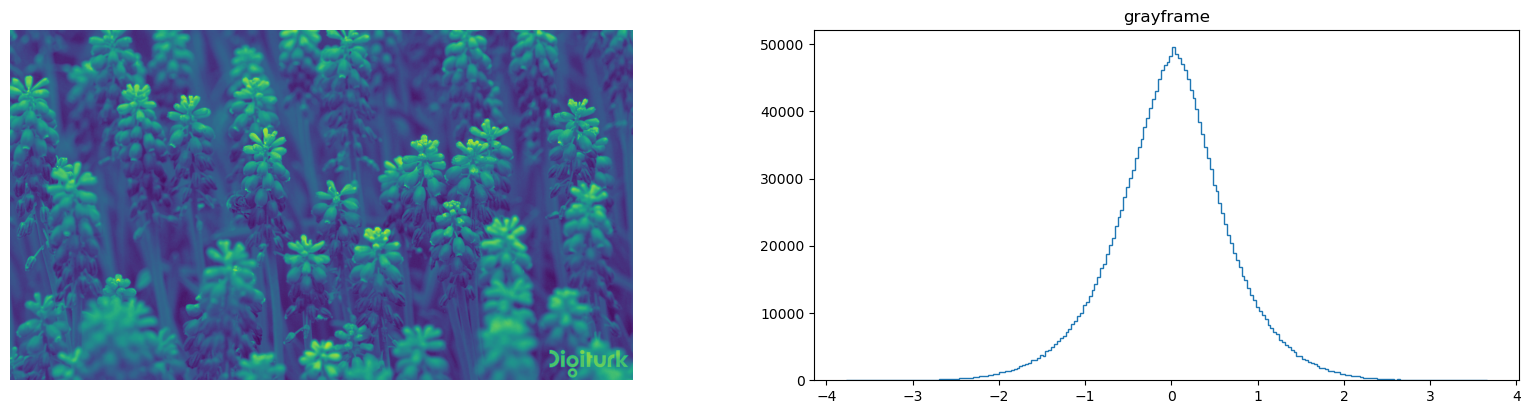

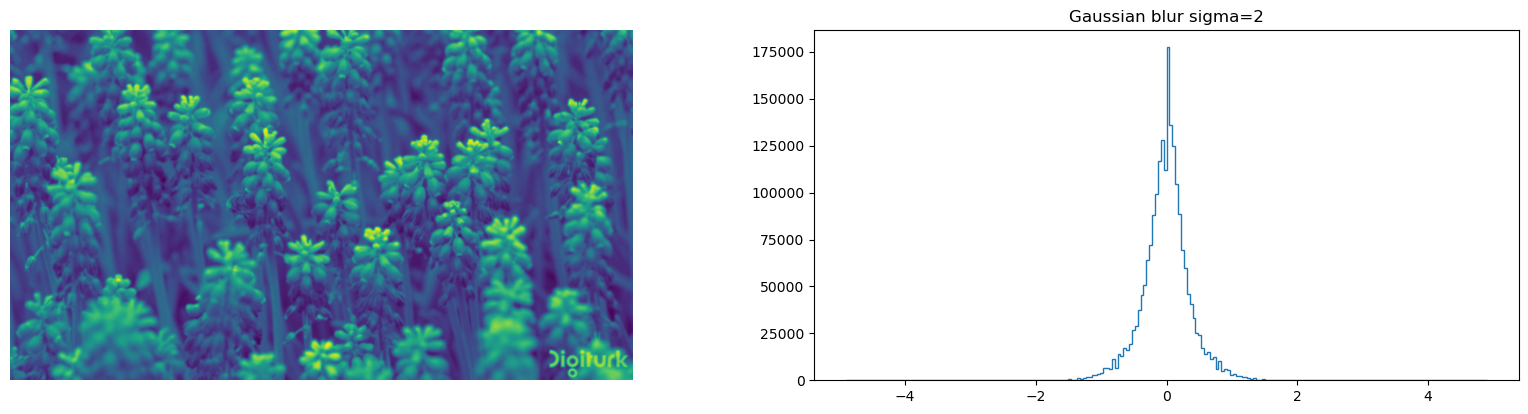

In [51]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(grayframe); plt.axis("off");
plt.subplot(2,2,2)
counts, bins = np.histogram(oimg.flatten(), bins=222)
plt.stairs(counts, bins);
plt.title('grayframe');

ksize = (25,25)
s = 2
blurframe = blurimg(grayframe, ksize, s)
oimg2 = divnormcoeffs(blurframe)
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(blurframe); plt.axis("off");
plt.subplot(2,2,2)
counts, bins = np.histogram(oimg2.flatten(), bins=222)
plt.stairs(counts, bins);
plt.title("Gaussian blur sigma="+str(s));

We notice that the the width of the gaussian epdf gets smaller as more values are concentrated at the center. This is because the guassian blur kernel has a smoothening effect and thus values within a patch are clustetring around a cenrtal value.

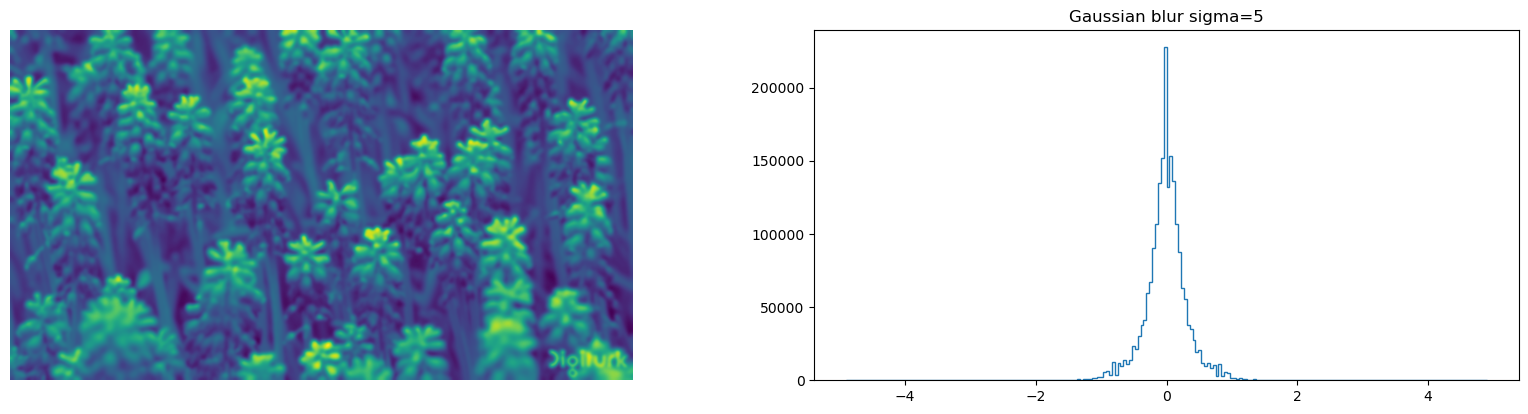

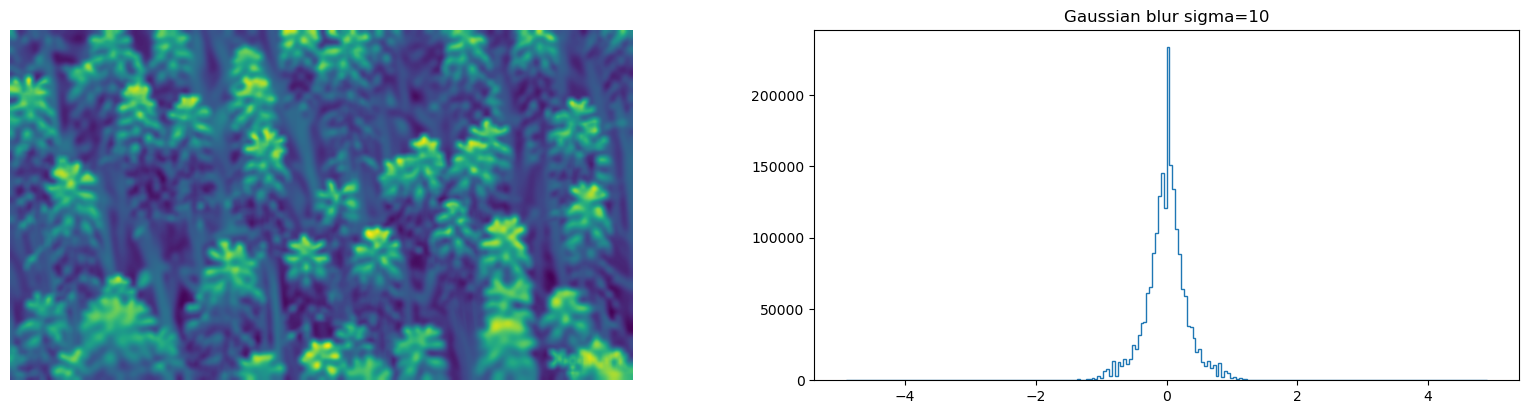

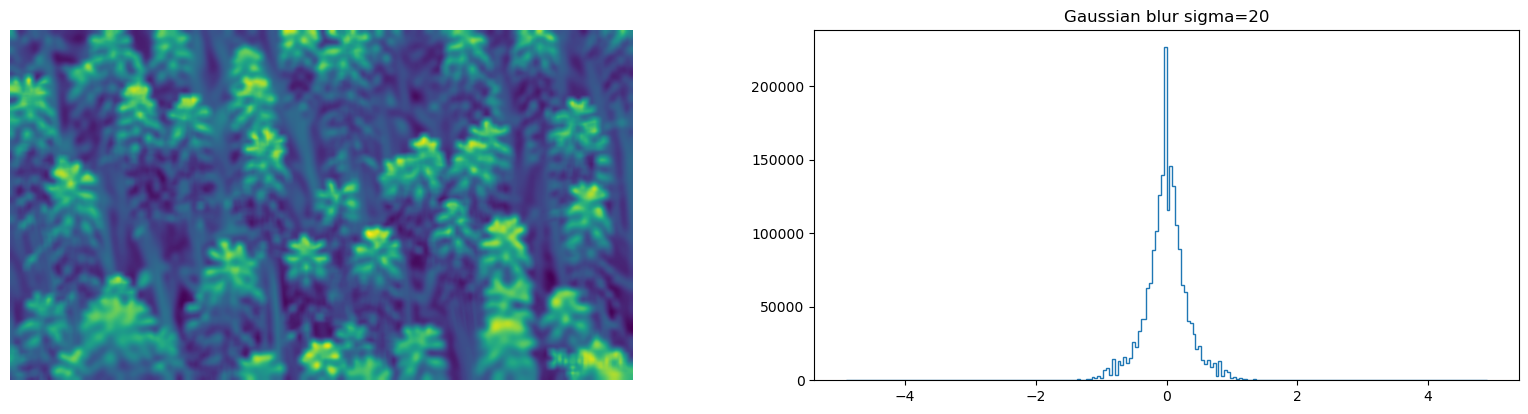

In [52]:
s = 5
blurframe3 = blurimg(grayframe, ksize, s)
oimg3 = divnormcoeffs(blurframe3)

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(blurframe3); plt.axis("off");
plt.subplot(2,2,2)
counts, bins = np.histogram(oimg3.flatten(), bins=222)
plt.stairs(counts, bins);
plt.title("Gaussian blur sigma="+str(s));

s = 10
blurframe4 = blurimg(grayframe, ksize, s)
oimg4 = divnormcoeffs(blurframe4)

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(blurframe4); plt.axis("off");
plt.subplot(2,2,2)
counts, bins = np.histogram(oimg4.flatten(), bins=222)
plt.stairs(counts, bins);
plt.title("Gaussian blur sigma="+str(s));

s = 20
blurframe5 = blurimg(grayframe, ksize, s)
oimg5 = divnormcoeffs(blurframe5)

plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.imshow(blurframe5); plt.axis("off");
plt.subplot(2,2,2)
counts, bins = np.histogram(oimg5.flatten(), bins=222)
plt.stairs(counts, bins);
plt.title("Gaussian blur sigma="+str(s));

As we increase the variance of the gaussian filter, the filter blurs a larger and larger area. As explained in the previoius paragraph, this results in a smoothening of the values and removal of high frequency components. This means that the values in a patch are more likely to be clustered around the mean. This leads to the gaussian EPDF getting narrower and narrower. 